In [1]:
# ---
# title: 11. CVaR (Conditional Value at Risk) Optimization
# tags: [Optimization, CVaR, RiskManagement, Finance]
# difficulty: Advanced
# ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cvxpy as cp

# Import our optimizer
import sys
sys.path.append('..')
from src.analytics.advanced_optimizer import AdvancedOptimizer
from src.analytics.portfolio_optimizer import PortfolioOptimizer

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Conditional Value at Risk (CVaR) Optimization

## Introduction

**Conditional Value at Risk (CVaR)**, also known as **Expected Shortfall (ES)**, is a risk measure that quantifies the expected loss in the worst-case scenarios.

### Why CVaR?

Traditional portfolio optimization uses **variance** as a risk measure, but variance has limitations:
1. **Symmetric**: Treats upside and downside volatility equally
2. **Ignores Tail Risk**: Doesn't focus on extreme losses
3. **Assumes Normality**: Breaks down with fat-tailed distributions

**CVaR addresses these issues** by:
- Focusing on **downside risk** (losses, not gains)
- Capturing **tail risk** (worst-case scenarios)
- Being a **coherent risk measure** (satisfies desirable mathematical properties)

## VaR vs CVaR

### Value at Risk (VaR)
**VaR at confidence level $\alpha$** answers: *"What is the maximum loss we expect with probability $\alpha$?"*

$$\text{VaR}_{\alpha} = \inf\{x : P(L \leq x) \geq \alpha\}$$

**Problem**: VaR tells you the threshold but not how bad losses can be beyond it.

### Conditional Value at Risk (CVaR)
**CVaR at confidence level $\alpha$** answers: *"What is the expected loss given that we exceed VaR?"*

$$\text{CVaR}_{\alpha} = E[L \mid L \geq \text{VaR}_{\alpha}]$$

**Advantage**: CVaR considers the **magnitude** of tail losses, not just the threshold.

## Mathematical Formulation

CVaR can be computed via optimization:

$$\text{CVaR}_{\alpha}(w) = \min_{\gamma} \left\{ \gamma + \frac{1}{(1-\alpha)T} \sum_{t=1}^{T} \max(0, -r_t^T w - \gamma) \right\}$$

Where:
- $w$ = Portfolio weights
- $r_t$ = Return vector at time $t$
- $\gamma$ = VaR threshold
- $\alpha$ = Confidence level (e.g., 0.95 for 95% VaR)

This is a **convex optimization problem** that can be solved efficiently.

## Step 1: Load Market Data

In [2]:
# Load returns from silver layer
silver_path = Path("../data/silver")
files = list(silver_path.glob("market_returns_*.parquet"))

if not files:
    raise FileNotFoundError("No returns data found. Run data ingestion first.")

latest = max(files, key=lambda f: f.stat().st_mtime)
returns = pd.read_parquet(latest)

print(f"Loaded returns for {len(returns.columns)} tickers")
print(f"Date range: {returns.index[0]} to {returns.index[-1]}")

# Use subset for demonstration
returns_subset = returns.iloc[:, :15]  # First 15 tickers
print(f"\nUsing {len(returns_subset.columns)} tickers for demonstration")

Loaded returns for 54 tickers
Date range: 2023-12-13 00:00:00 to 2025-12-12 00:00:00

Using 15 tickers for demonstration


## Step 2: Visualize Return Distribution

Let's examine the distribution of returns to understand tail risk.

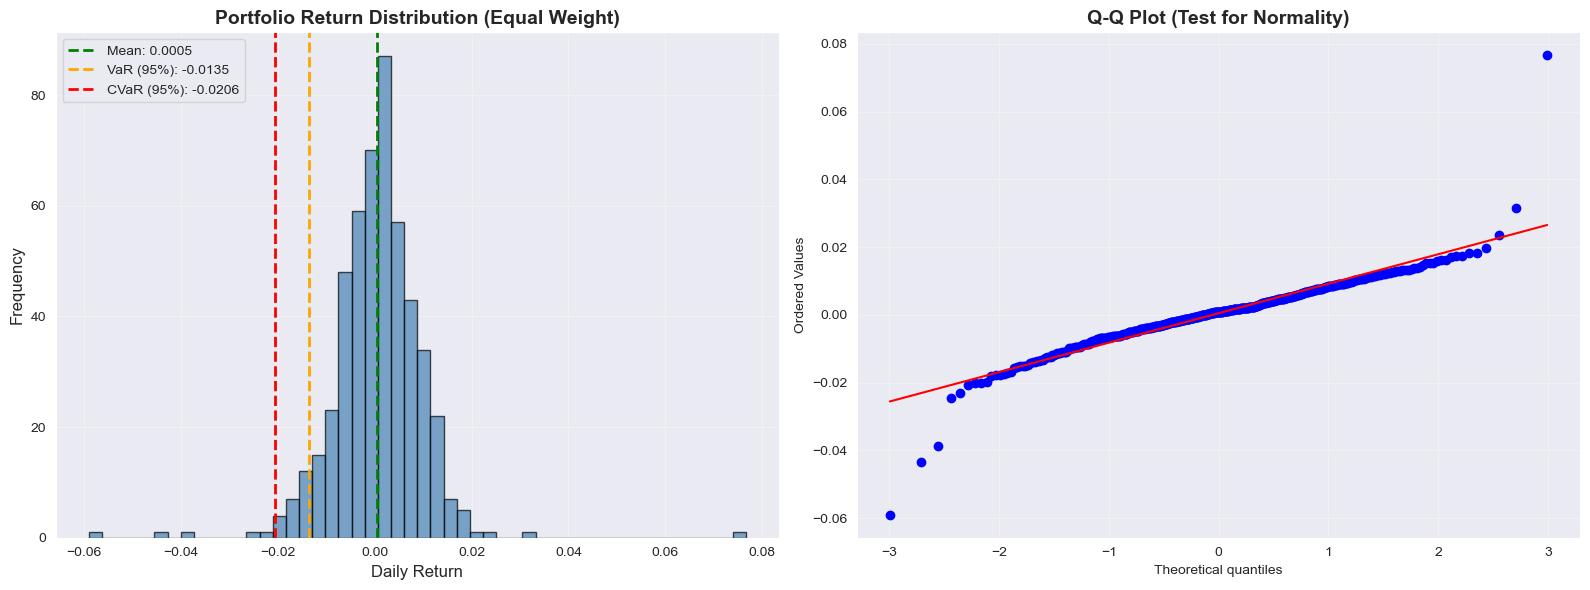


📊 Risk Metrics (Equal Weight Portfolio):
VaR (95%):  -0.0135 (-1.35%)
CVaR (95%): -0.0206 (-2.06%)

Interpretation:
- 5% of days have losses worse than -1.35%
- On those worst 5% of days, average loss is -2.06%


In [3]:
# Calculate equal-weight portfolio returns
equal_weights = pd.Series(1/len(returns_subset.columns), index=returns_subset.columns)
portfolio_returns = (returns_subset * equal_weights).sum(axis=1)

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram with VaR/CVaR markers
axes[0].hist(portfolio_returns, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(portfolio_returns.mean(), color='green', linestyle='--', 
                linewidth=2, label=f'Mean: {portfolio_returns.mean():.4f}')

# Calculate VaR and CVaR at 95% confidence
alpha = 0.95
var_95 = portfolio_returns.quantile(1 - alpha)
cvar_95 = portfolio_returns[portfolio_returns <= var_95].mean()

axes[0].axvline(var_95, color='orange', linestyle='--', 
                linewidth=2, label=f'VaR (95%): {var_95:.4f}')
axes[0].axvline(cvar_95, color='red', linestyle='--', 
                linewidth=2, label=f'CVaR (95%): {cvar_95:.4f}')

axes[0].set_title('Portfolio Return Distribution (Equal Weight)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Daily Return', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3)

# Q-Q plot to check normality
from scipy import stats
stats.probplot(portfolio_returns, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Test for Normality)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Risk Metrics (Equal Weight Portfolio):")
print(f"VaR (95%):  {var_95:.4f} ({var_95*100:.2f}%)")
print(f"CVaR (95%): {cvar_95:.4f} ({cvar_95*100:.2f}%)")
print(f"\nInterpretation:")
print(f"- 5% of days have losses worse than {var_95*100:.2f}%")
print(f"- On those worst 5% of days, average loss is {cvar_95*100:.2f}%")

## Step 3: Optimize Portfolio Using CVaR

Now let's find the portfolio that **minimizes CVaR** (tail risk).

In [4]:
# Initialize optimizer
optimizer = AdvancedOptimizer()

# Compute CVaR-optimal weights
print("Optimizing portfolio to minimize CVaR...\n")
cvar_weights = optimizer.get_cvar_weights(returns_subset, alpha=0.95)

print("=== CVaR-Optimal Portfolio Weights ===")
print(cvar_weights.sort_values(ascending=False))
print(f"\nSum of weights: {cvar_weights.sum():.6f}")
print(f"Number of positions > 1%: {(cvar_weights > 0.01).sum()}")

Optimizing portfolio to minimize CVaR...

CVaR (ECOS): Solver failed with error: The solver ECOS is not installed.
Error in LDL factorization when computing the nonzero elements. The problem seems to be non-convex.
factor_status: 501, num_vars: 518
Error in LDL initial factorization.
ERROR: init_lin_sys_work failure
CVaR (SCS): Solver failed with error: ScsWork allocation error!
ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.
CVaR (OSQP): Solver failed with error: 4

CVaR Optimization failed with all solvers.
Falling back to Minimum Variance Portfolio (similar risk objective)...


AttributeError: 'AdvancedOptimizer' object has no attribute '_get_min_variance_weights'

## Step 4: Compare CVaR vs Mean-Variance Optimization

Let's compare the CVaR-optimal portfolio with traditional MVO.

In [ ]:
# Compute MVO weights
mvo_optimizer = PortfolioOptimizer()
mvo_weights = mvo_optimizer.get_max_sharpe_weights(returns_subset)

# Create comparison dataframe
weight_comparison = pd.DataFrame({
    'CVaR-Optimal': cvar_weights,
    'MVO (Max Sharpe)': mvo_weights,
    'Equal Weight': equal_weights
}).fillna(0)

# Plot weight comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (col, color) in enumerate(zip(weight_comparison.columns, 
                                      ['darkred', 'steelblue', 'gray'])):
    weight_comparison[col].sort_values(ascending=True).plot(
        kind='barh', ax=axes[i], color=color, alpha=0.8
    )
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Weight', fontsize=10)
    axes[i].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate concentration
def herfindahl_index(weights):
    return (weights ** 2).sum()

print("\n=== Portfolio Concentration (Herfindahl Index) ===")
for col in weight_comparison.columns:
    hhi = herfindahl_index(weight_comparison[col])
    print(f"{col:20s}: {hhi:.4f}")
print("\n(Lower = More diversified)")

## Step 5: Compare Return Distributions

Let's visualize how CVaR optimization affects the return distribution.

In [ ]:
# Calculate portfolio returns for each strategy
returns_dict = {}
for col in weight_comparison.columns:
    returns_dict[col] = (returns_subset * weight_comparison[col]).sum(axis=1)

# Plot overlapping distributions
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Subplot 1: Overlapping histograms
for strategy, rets in returns_dict.items():
    axes[0].hist(rets, bins=50, alpha=0.5, label=strategy, edgecolor='black')

axes[0].set_title('Return Distribution Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Daily Return', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3)

# Subplot 2: Cumulative distribution (focus on left tail)
for strategy, rets in returns_dict.items():
    sorted_rets = np.sort(rets)
    cumulative = np.arange(1, len(sorted_rets) + 1) / len(sorted_rets)
    axes[1].plot(sorted_rets, cumulative, label=strategy, linewidth=2)

axes[1].set_title('Cumulative Distribution (Left Tail Focus)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Daily Return', fontsize=12)
axes[1].set_ylabel('Cumulative Probability', fontsize=12)
axes[1].set_xlim([-0.05, 0.02])  # Focus on left tail
axes[1].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[1].legend(loc='upper left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("- CVaR-optimal portfolio should have a 'thinner' left tail")
print("- This means fewer extreme negative returns")
print("- Trade-off: May sacrifice some upside potential")

## Step 6: Risk Metrics Comparison

Let's calculate comprehensive risk metrics for all strategies.

In [ ]:
def calculate_risk_metrics(returns, alpha=0.95):
    """Calculate comprehensive risk metrics"""
    var = returns.quantile(1 - alpha)
    cvar = returns[returns <= var].mean()
    
    return {
        'Mean Return': returns.mean(),
        'Volatility': returns.std(),
        'Skewness': returns.skew(),
        'Kurtosis': returns.kurtosis(),
        f'VaR ({alpha:.0%})': var,
        f'CVaR ({alpha:.0%})': cvar,
        'Min Return': returns.min(),
        'Max Return': returns.max()
    }

# Calculate metrics for all strategies
risk_metrics = {}
for strategy, rets in returns_dict.items():
    risk_metrics[strategy] = calculate_risk_metrics(rets)

metrics_df = pd.DataFrame(risk_metrics).T

print("\n=== Comprehensive Risk Metrics ===")
print(metrics_df.to_string())

# Visualize key metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mean vs Volatility
axes[0, 0].scatter(metrics_df['Volatility'], metrics_df['Mean Return'], s=200, alpha=0.7)
for idx, row in metrics_df.iterrows():
    axes[0, 0].annotate(idx, (row['Volatility'], row['Mean Return']), 
                        fontsize=10, ha='center')
axes[0, 0].set_xlabel('Volatility (Risk)', fontsize=12)
axes[0, 0].set_ylabel('Mean Return', fontsize=12)
axes[0, 0].set_title('Risk-Return Trade-off', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Plot 2: VaR comparison
metrics_df['VaR (95%)'].plot(kind='bar', ax=axes[0, 1], color='orange', alpha=0.8)
axes[0, 1].set_title('Value at Risk (95%)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('VaR', fontsize=12)
axes[0, 1].axhline(0, color='black', linewidth=0.8)
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: CVaR comparison
metrics_df['CVaR (95%)'].plot(kind='bar', ax=axes[1, 0], color='red', alpha=0.8)
axes[1, 0].set_title('Conditional VaR (95%)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('CVaR', fontsize=12)
axes[1, 0].axhline(0, color='black', linewidth=0.8)
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Skewness and Kurtosis
x = np.arange(len(metrics_df))
width = 0.35
axes[1, 1].bar(x - width/2, metrics_df['Skewness'], width, label='Skewness', alpha=0.8)
axes[1, 1].bar(x + width/2, metrics_df['Kurtosis'], width, label='Kurtosis', alpha=0.8)
axes[1, 1].set_title('Distribution Shape', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Value', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_df.index, rotation=45)
axes[1, 1].legend()
axes[1, 1].axhline(0, color='black', linewidth=0.8)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ CVaR-Optimal portfolio should have:")
print("   - Lowest (least negative) CVaR")
print("   - Reduced tail risk (higher minimum return)")
print("   - Potentially lower kurtosis (fewer extreme events)")

## Step 7: Sensitivity to Confidence Level

Let's explore how different confidence levels affect the CVaR-optimal portfolio.

In [ ]:
# Test different alpha levels
alpha_levels = [0.90, 0.95, 0.99]
cvar_portfolios = {}

for alpha in alpha_levels:
    weights = optimizer.get_cvar_weights(returns_subset, alpha=alpha)
    cvar_portfolios[f'CVaR-{alpha:.0%}'] = weights

# Create comparison dataframe
alpha_comparison = pd.DataFrame(cvar_portfolios).fillna(0)

# Plot weight differences
alpha_comparison.plot(kind='bar', figsize=(14, 6), alpha=0.8)
plt.title('CVaR-Optimal Weights at Different Confidence Levels', 
          fontsize=14, fontweight='bold')
plt.ylabel('Weight', fontsize=12)
plt.xlabel('Ticker', fontsize=12)
plt.legend(title='Confidence Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("- Higher α (e.g., 99%) focuses on more extreme tail events")
print("- Lower α (e.g., 90%) considers a broader range of losses")
print("- Portfolio composition changes based on which tail we target")

## Key Takeaways

### ✅ Advantages of CVaR Optimization:
1. **Tail Risk Focus**: Explicitly minimizes worst-case losses
2. **Coherent Risk Measure**: Satisfies sub-additivity, monotonicity, translation invariance
3. **Convex Optimization**: Efficient to solve, guaranteed global optimum
4. **Downside Protection**: Better for risk-averse investors concerned with drawdowns
5. **Regulatory Compliance**: Widely used in Basel III and risk management frameworks

### ⚠️ Limitations:
1. **Historical Dependency**: Based on historical returns (may not predict future tail events)
2. **Computational Cost**: More complex than variance-based optimization
3. **Return Trade-off**: May sacrifice expected returns for tail risk reduction
4. **Data Requirements**: Needs sufficient historical data to estimate tail behavior

### 🎯 When to Use CVaR Optimization:
- **Risk-Averse Investors**: Those prioritizing capital preservation over maximum returns
- **Institutional Mandates**: Pension funds, insurance companies with strict risk limits
- **Crisis Periods**: When tail risk is elevated (high volatility regimes)
- **Leveraged Portfolios**: Where extreme losses could trigger margin calls
- **Regulatory Requirements**: When CVaR/ES is mandated for risk reporting

### 🔬 Practical Considerations:
1. **Confidence Level**: 95% is standard, but 99% for more conservative portfolios
2. **Rolling Windows**: Use rolling CVaR to adapt to changing market conditions
3. **Stress Testing**: Complement with scenario analysis and stress tests
4. **Combine with Other Metrics**: Use alongside Sharpe ratio, max drawdown, etc.

### 📊 CVaR vs Other Risk Measures:
| Measure | Pros | Cons |
|---------|------|------|
| **Variance** | Simple, analytical solution | Symmetric, ignores tails |
| **VaR** | Easy to interpret | Not coherent, ignores tail magnitude |
| **CVaR** | Coherent, tail-focused | Computationally intensive |
| **Max Drawdown** | Intuitive for investors | Depends on single worst period |

### 📚 Further Reading:
- Rockafellar, R.T. & Uryasev, S. (2000). "Optimization of Conditional Value-at-Risk"
- Acerbi, C. & Tasche, D. (2002). "On the Coherence of Expected Shortfall"
- Krokhmal, P. et al. (2002). "Portfolio Optimization with Conditional Value-at-Risk"
- Basel Committee on Banking Supervision (2016). "Minimum Capital Requirements for Market Risk"